In [25]:
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
%pylab inline
import os
from __future__ import print_function
from __future__ import division
import os, sys
# hook up all scripts
sys.path.append(os.path.abspath('../scripts')) # if notebook in folder
sys.path.append(os.path.abspath('./scripts')) #if in root
import preprocessing_time_series as pts

os.chdir(pts.working_dir() + 'Feature_releases/release_v02/')

Populating the interactive namespace from numpy and matplotlib


In [26]:
data_train = pd.read_csv('train_Queretaro de Arteaga.csv')
print(data_train.shape)
data_train.head()

(529832, 237)


,Agencia_ID,Canal_ID,Cliente_ID,Demanda_uni_equil,Dev_proxima,Dev_proxima_by_uni,Dev_uni_proxima,Log_Demanda,Log_Demanda_Mean_Producto_ID_Cliente_ID_Agencia_ID,Log_Demanda_Mean_Producto_ID_Cliente_ID_Ruta_SAK,...,No_remains_Mean_Producto_ID_Ruta_SAK_4last,No_remains_Mean_brand_Cliente_ID_Agencia_ID_4last,Ordered_4last,Ordered_Mean_Producto_ID_Cliente_ID_Agencia_ID_4last,Ordered_Mean_Producto_ID_Cliente_ID_Ruta_SAK_4last,Ordered_Mean_Producto_ID_Ruta_SAK_4last,Ordered_Mean_brand_Cliente_ID_Agencia_ID_4last,Venta_hoy_4last,Venta_hoy_by_uni_4last,Venta_uni_hoy_4last
0,1210,5,653039,395.0,0.00,NaN,0.0,5.981414,5.712620,6.255725,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1210,5,653039,575.0,64.82,9.26,7.0,6.356108,6.137538,6.605798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1210,5,653039,223.0,0.00,NaN,0.0,5.411646,3.830277,5.193466,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1210,5,653039,40.0,0.00,NaN,0.0,3.713572,4.586806,4.949039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1210,5,653039,182.0,0.00,NaN,0.0,5.209486,5.206432,5.203316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
means_by_split = [x for x in data_train.columns if 'Mean' in x and not(x[-2] == '_' or x[-4:] == 'last')] #its mean, its not a lag
print(means_by_split)
data_for_model = data_train.fillna(-9).drop([u'Town', u'State', u'Venta_uni_hoy', u'Venta_hoy', u'Dev_uni_proxima',
       u'Dev_proxima', u'Demanda_uni_equil', u'Dev_proxima_by_uni', u'No_remains', 
        u'Venta_hoy_by_uni', u'Ordered'] + means_by_split, axis=1).set_index(u'Semana')

['Log_Demanda_Mean_Producto_ID_Cliente_ID_Agencia_ID', 'Log_Demanda_Mean_Producto_ID_Cliente_ID_Ruta_SAK', 'Log_Demanda_Mean_Producto_ID_Ruta_SAK', 'Log_Demanda_Mean_brand_Cliente_ID_Agencia_ID', 'Log_Venta_uni_hoy_Mean_Producto_ID_Cliente_ID_Agencia_ID', 'Log_Venta_uni_hoy_Mean_Producto_ID_Cliente_ID_Ruta_SAK', 'Log_Venta_uni_hoy_Mean_Producto_ID_Ruta_SAK', 'Log_Venta_uni_hoy_Mean_brand_Cliente_ID_Agencia_ID', 'No_remains_Mean_Producto_ID_Cliente_ID_Agencia_ID', 'No_remains_Mean_Producto_ID_Cliente_ID_Ruta_SAK', 'No_remains_Mean_Producto_ID_Ruta_SAK', 'No_remains_Mean_brand_Cliente_ID_Agencia_ID', 'Ordered_Mean_Producto_ID_Cliente_ID_Agencia_ID', 'Ordered_Mean_Producto_ID_Cliente_ID_Ruta_SAK', 'Ordered_Mean_Producto_ID_Ruta_SAK', 'Ordered_Mean_brand_Cliente_ID_Agencia_ID']


In [35]:
X_train = data_for_model[feat_50].loc[3:7,:]
y_train = data_for_model.loc[3:7,:]['Log_Demanda']
X_test = data_for_model[feat_50].loc[8:9,:]
y_test = data_for_model.loc[8:9,:]['Log_Demanda']
X_train.head()

,Cliente_ID,Ruta_SAK,Producto_ID,weight,Log_Demanda_4last,pieces,Venta_hoy_1,Log_Demanda_Mean_brand_Cliente_ID_Agencia_ID_1,Log_Demanda_Mean_Producto_ID_Cliente_ID_Agencia_ID_1,Demanda_uni_equil_4last,...,Venta_hoy_4,Log_Demanda_Mean_Producto_ID_Cliente_ID_Ruta_SAK_3,Log_Dev_proxima,Demanda_uni_equil_2,Venta_uni_hoy_4last,Venta_hoy_by_uni_4last,No_remains_Mean_brand_Cliente_ID_Agencia_ID_3,Log_Demanda_Mean_brand_Cliente_ID_Agencia_ID_4,No_remains_Mean_Producto_ID_Ruta_SAK_3,Log_Demanda_Mean_Producto_ID_Ruta_SAK_2last
Semana,,,,,,,,,,,,,,,,,,,,,
3,653039,3001,1240,125.0,-9.0,4.0,-9.0,-9.0,-9.0,-9.0,...,-9.0,-9.0,0.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
3,653039,3001,1250,105.0,-9.0,4.0,-9.0,-9.0,-9.0,-9.0,...,-9.0,-9.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
3,653039,3001,1644,40.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.0,-9.0,0.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
3,653039,3001,2261,58.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.0,-9.0,0.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
3,653039,3001,4280,110.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.0,-9.0,0.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0


# xgboost 

Обнаружил, что для learning_rate=0.3 оптимальное количество деревьев 100.

Подобраны параметры max_depth=16 и min_child_weight=18.

Подбираю gamma

Потом надо подобрать [subsample, colsample_bytree], [lambda(L2), alpha(L1)]. 

In [36]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error

def plot_feature_importances(xgb_model):
    plt.figure(figsize=(20,10))
    feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [37]:
# param = clf.best_params_
param = {
 'learning_rate': 0.3,
 'gamma': 1,
 'max_depth': 16,
 'min_child_weight': 18,
 'n_estimators': 100,
 'subsample': 0.8,
 'colsample_bytree': 0.8
}

xgb_model = xgb.XGBRegressor()
xgb_model.set_params(**param)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=1, learning_rate=0.3, max_delta_step=0, max_depth=16,
       min_child_weight=18, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

Train: 0.330551992018
Test: 0.340312947787


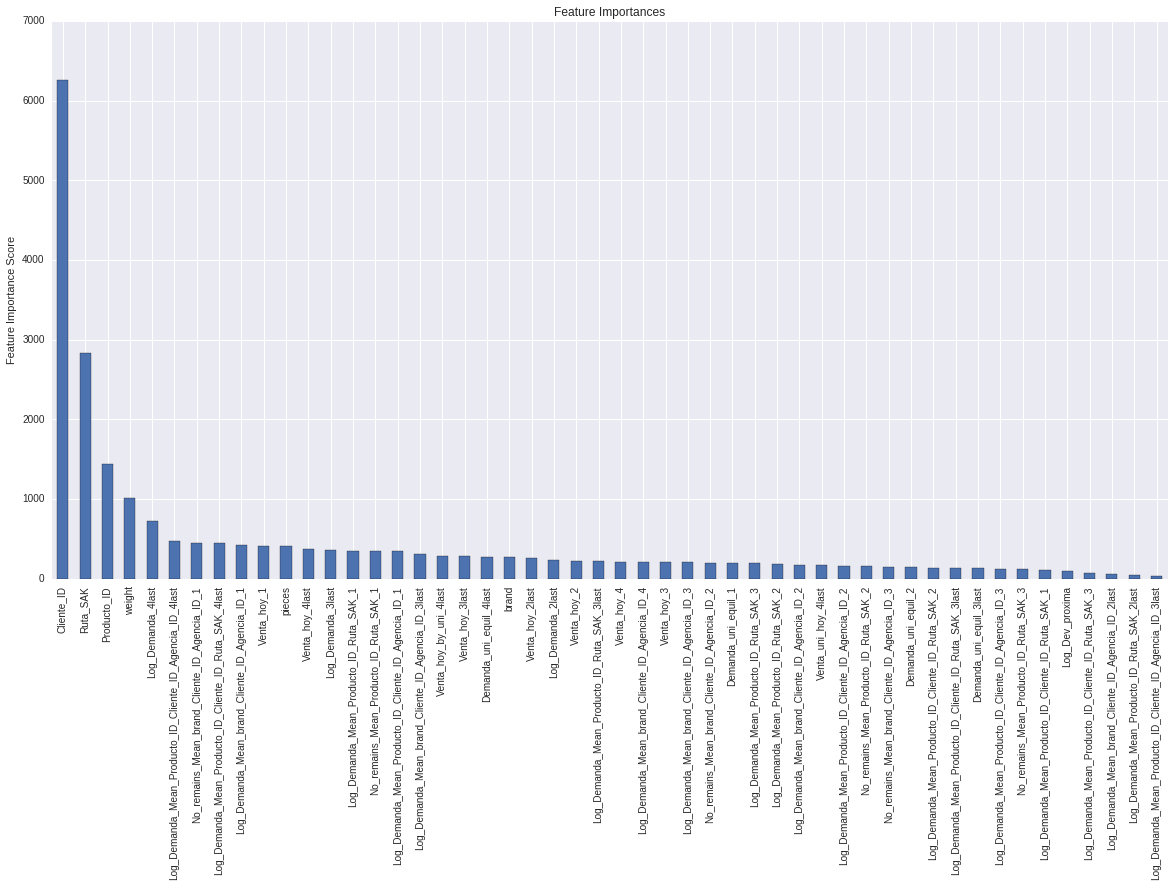

In [38]:
plot_feature_importances(xgb_model)

print('Train:', np.sqrt(mean_squared_error(y_train, xgb_model.predict(X_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test))))

In [19]:
feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False)
feat_imp.to_csv('feat_imp_xgboost_release_v02.csv')

In [32]:
feat_50 = list(feat_imp[:50].index)

In [33]:
feat_50

['Cliente_ID',
 'Ruta_SAK',
 'Producto_ID',
 'weight',
 'Log_Demanda_4last',
 'pieces',
 'Venta_hoy_1',
 'Log_Demanda_Mean_brand_Cliente_ID_Agencia_ID_1',
 'Log_Demanda_Mean_Producto_ID_Cliente_ID_Agencia_ID_1',
 'Demanda_uni_equil_4last',
 'Log_Demanda_Mean_Producto_ID_Cliente_ID_Agencia_ID_4last',
 'Log_Demanda_Mean_Producto_ID_Ruta_SAK_1',
 'Log_Demanda_3last',
 'brand',
 'Venta_hoy_4last',
 'Venta_hoy_3last',
 'Venta_hoy_2last',
 'Venta_hoy_2',
 'No_remains_Mean_brand_Cliente_ID_Agencia_ID_1',
 'No_remains_Mean_Producto_ID_Ruta_SAK_1',
 'Log_Demanda_Mean_Producto_ID_Cliente_ID_Ruta_SAK_4last',
 'Log_Demanda_2last',
 'Log_Demanda_Mean_Producto_ID_Ruta_SAK_2',
 'Log_Demanda_Mean_Producto_ID_Cliente_ID_Ruta_SAK_3last',
 'Log_Demanda_Mean_Producto_ID_Cliente_ID_Ruta_SAK_1',
 'Demanda_uni_equil_1',
 'Log_Demanda_Mean_Producto_ID_Cliente_ID_Agencia_ID_2',
 'Log_Demanda_Mean_brand_Cliente_ID_Agencia_ID_3last',
 'Log_Demanda_Mean_brand_Cliente_ID_Agencia_ID_2',
 'Log_Demanda_Mean_brand_Cli

# Next week prediction

In [20]:
X_train2 = X_train[[col for col in X_train.columns if '_1' != col[-2:]]]
X_test2 = X_test[[col for col in X_test.columns if '_1' != col[-2:]]]
X_train2.shape, X_train.shape

((345204, 180), (345204, 208))

In [21]:
param = {
 'learning_rate': 0.3,
 'gamma': 1,
 'max_depth': 16,
 'min_child_weight': 18,
 'n_estimators': 100,
 'subsample': 0.8,
 'colsample_bytree': 0.8
}

xgb_model2 = xgb.XGBRegressor()
xgb_model2.set_params(**param)

xgb_model2.fit(X_train2, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=1, learning_rate=0.3, max_delta_step=0, max_depth=16,
       min_child_weight=18, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

Train: 0.332837642348
Test: 0.332240653692


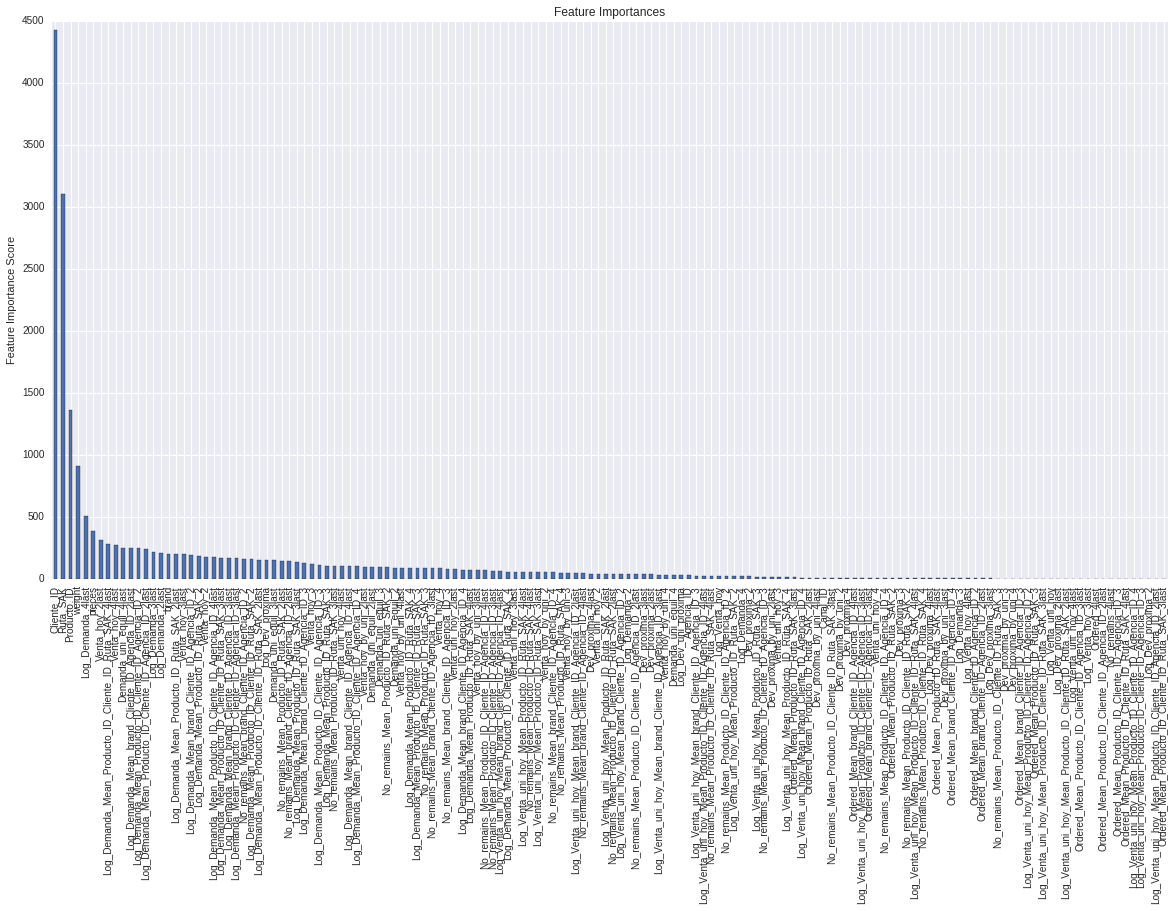

In [22]:
plot_feature_importances(xgb_model2)

print('Train:', np.sqrt(mean_squared_error(y_train, xgb_model2.predict(X_train2))))
print('Test:', np.sqrt(mean_squared_error(y_test, xgb_model2.predict(X_test2))))

# Cross-validation

In [ ]:
param = {
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 15,
 'min_child_weight': 12,
 'n_estimators': 100,
 'subsample': 0.8,
 'colsample_bytree': 0.8
}

xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
cvresult = xgb.cv(param, xgtrain, num_boost_round=200, nfold=5,
                    metrics='rmse', early_stopping_rounds=10)
cvresult

In [ ]:
grid_param = {
 'max_depth': [15, 17, 20, 23, 25],
 'min_child_weight': [5, 8, 10, 12],
}

xgb_model = xgb.XGBRegressor(n_estimators=78,
                             learning_rate = 0.3,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8)

clf = GridSearchCV(xgb_model, grid_param, cv=5,
                   scoring='mean_squared_error',verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)

print(clf.best_score_)
print(clf.best_params_)
clf.grid_scores_

In [ ]:
plot_feature_importances(clf.best_estimator_)

# Grid search without cross-validation

In [ ]:
from gridsearch import GridSearch

In [ ]:
param_grid = {
 'gamma': list(np.arange(0, 1, 0.05)),
}

xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate = 0.3,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             max_depth = 16,
                             min_child_weight = 18)

gs = GridSearch(xgb_model, param_grid, verbose=1)
    
gs.fit(X_train, X_test, y_train, y_test)

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_